In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats
from numpy.linalg import inv
import pandas_datareader as pdr
%matplotlib inline

In [2]:
# OLD DATA LOADING
"""

data = pd.read_csv("data/Portfolios_Formed_on_INV-2.csv",skiprows=17,index_col=0,parse_dates=True,nrows=691) 
data = data.dropna()
data.index = pd.to_datetime(data.index,format="%Y%m")

factors = pd.read_csv("data/F-F_Research_Data_Factors.csv",skiprows=3,index_col=0,parse_dates=True,nrows=1134) 
factors = factors.dropna()
factors.index = pd.to_datetime(factors.index,format="%Y%m")
rm = factors["Mkt-RF"]
rf = factors["RF"]

portfolio_25 = pd.read_csv("data/25_Portfolios_5x5.csv",skiprows=15,index_col="DATE",parse_dates=True,nrows=1134) 
portfolio_25 = portfolio_25.dropna()
portfolio_25.index = pd.to_datetime(portfolio_25.index,format="%Y%m")

portfolio_25 = portfolio_25["1963-07-01":"2020-06-01"]
data = data["1963-07-01":"2020-06-01"]
rm = rm["1963-07-01":"2020-06-01"]
rf = rf["1963-07-01":"2020-06-01"]
factors = factors["1963-07-01":"2020-06-01"]
ex_data = data.subtract(rf,axis=0)
portfolio_25_excess = portfolio_25.sub(rf,axis=0)
factors = factors.drop("RF",axis=1)

"""

'\n\ndata = pd.read_csv("data/Portfolios_Formed_on_INV-2.csv",skiprows=17,index_col=0,parse_dates=True,nrows=691) \ndata = data.dropna()\ndata.index = pd.to_datetime(data.index,format="%Y%m")\n\nfactors = pd.read_csv("data/F-F_Research_Data_Factors.csv",skiprows=3,index_col=0,parse_dates=True,nrows=1134) \nfactors = factors.dropna()\nfactors.index = pd.to_datetime(factors.index,format="%Y%m")\nrm = factors["Mkt-RF"]\nrf = factors["RF"]\n\nportfolio_25 = pd.read_csv("data/25_Portfolios_5x5.csv",skiprows=15,index_col="DATE",parse_dates=True,nrows=1134) \nportfolio_25 = portfolio_25.dropna()\nportfolio_25.index = pd.to_datetime(portfolio_25.index,format="%Y%m")\n\nportfolio_25 = portfolio_25["1963-07-01":"2020-06-01"]\ndata = data["1963-07-01":"2020-06-01"]\nrm = rm["1963-07-01":"2020-06-01"]\nrf = rf["1963-07-01":"2020-06-01"]\nfactors = factors["1963-07-01":"2020-06-01"]\nex_data = data.subtract(rf,axis=0)\nportfolio_25_excess = portfolio_25.sub(rf,axis=0)\nfactors = factors.drop("RF",a

In [3]:
data = pdr.get_data_famafrench("Portfolios_Formed_on_INV",start="1963-07",end="2020-06")[0]
portfolio_25 = pdr.get_data_famafrench("25_Portfolios_5x5", start="1963-07", end="2020-06")[0]

factors = pdr.get_data_famafrench("F-F_Research_Data_Factors", start="1963-07", end="2020-06")[0] 
rm = factors["Mkt-RF"]
rf = factors["RF"]

ex_data = data.subtract(rf,axis=0)
portfolio_25_excess = portfolio_25.sub(rf,axis=0)
factors = factors.drop("RF",axis=1)

In [4]:
data

,Lo 30,Med 40,Hi 30,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
Date,,,,,,,,,,,,,,,,,,
1963-07,-1.23,0.55,0.12,-1.14,-0.34,0.66,0.17,0.64,-2.07,-0.15,-1.42,0.37,1.17,0.38,0.51,-0.55,0.50,1.05
1963-08,6.03,4.78,6.05,6.22,5.22,5.11,4.65,6.67,5.37,7.11,5.62,4.95,5.57,4.87,4.39,5.22,6.32,7.68
1963-09,-1.16,-1.40,-0.63,-1.15,-0.97,-2.81,-0.13,-1.16,-0.67,-1.65,-1.16,-0.84,-2.67,-2.88,-0.23,0.09,-0.94,-1.79
1963-10,2.10,1.83,6.68,2.48,0.98,0.55,4.00,7.81,2.79,2.15,1.27,0.78,0.79,0.43,3.44,5.18,8.86,4.82
1963-11,0.08,0.14,-2.59,0.52,-1.13,-1.10,0.90,-3.82,1.98,-1.00,-0.91,-1.27,-1.68,-0.78,1.79,-0.92,-4.92,-0.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02,-8.99,-8.67,-6.51,-8.31,-9.56,-9.48,-6.34,-6.62,-7.48,-9.08,-9.64,-9.44,-8.35,-10.22,-6.43,-6.24,-7.39,-5.12
2020-03,-11.49,-14.59,-13.11,-11.27,-13.94,-15.86,-11.86,-12.66,-10.35,-12.13,-11.71,-17.46,-16.26,-15.59,-9.84,-14.21,-12.01,-13.91
2020-04,12.99,12.30,15.75,12.65,13.44,12.22,13.01,16.10,13.81,11.55,13.31,13.66,12.30,12.17,11.47,14.89,16.31,15.67


In [5]:
# b, CAPM for the 10 investment portfolios, plot alphas against investment deciles
alphas = []
betas = []
for i in range(8,18):
    y = ex_data.iloc[:,i]
    x = sm.add_constant(rm)
    res = sm.OLS(y,x,cov_type="HC0").fit()
    alphas.append(res.params[0])
    betas.append(res.params[1])

alphas = pd.DataFrame(alphas).T
alphas.columns = ["Lo 10","Dec 2", "Dec 3","Dec 4","Dec 5", "Dec 6", "Dec 7","Dec 8", "Dec 9", "Hi 10"]
alphas.index = ["Pricing error"]
alphas = alphas.T

In [6]:
alphas

,Pricing error
Lo 10,0.167358
Dec 2,0.233005
Dec 3,0.185294
Dec 4,0.103203
Dec 5,0.090755
Dec 6,0.051453
Dec 7,0.115504
Dec 8,-0.010789
Dec 9,0.022597
Hi 10,-0.321981


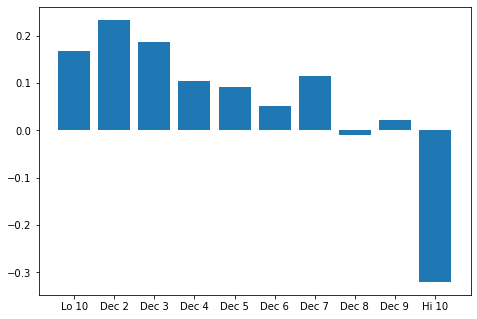

In [35]:

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ["Lo 10","Dec 2" ,"Dec 3","Dec 4","Dec 5", "Dec 6", "Dec 7","Dec 8", "Dec 9", "Hi 10"]
a = [alphas.iloc[0],alphas.iloc[1],alphas.iloc[2],alphas.iloc[3],alphas.iloc[4],alphas.iloc[5],alphas.iloc[6],alphas.iloc[7],alphas.iloc[8],-0.32]
ax.bar(langs,a)
plt.show()


In [8]:
inv_growth = data["Hi 30"] - data["Lo 30"]
factors_inv = factors.copy()
factors_inv["INV"] = inv_growth
factors_inv.mean()

Mkt-RF    0.536681
SMB       0.185702
HML       0.256213
INV      -0.195731
dtype: float64

In [26]:
def calc_GRS(alpha_vector, factor_dataframe, asset_returns,e_cov):
    gen_cov = factor_dataframe.cov()
    generalized_sharpe = factor_dataframe.mean().T @ inv(gen_cov) @ factor_dataframe.mean()     #Cochrane 2005, p.217
    #cov = asset_returns.cov()
    cov = e_cov
    if isinstance(alpha_vector, list):
        alpha_vector = np.array(alpha_vector)
    #Calc GRS
    df = len(asset_returns) - len(asset_returns.columns) - len(factor_dataframe.columns) # T - N - K     (N = number of assets, K = number of factors)
    N = len(asset_returns.columns)
    GRS = (df/ N) * ((alpha_vector.T @ inv(cov) @ alpha_vector) / (1+ generalized_sharpe))
    p = 1-scipy.stats.f.cdf(GRS, len(asset_returns.columns), df) #find p-value of F test statistic
    return GRS, p

# 3 d

inv_alphas = []
inv_tvalues = []
inv_adj_rsq = []

for column in portfolio_25_excess:
    x = sm.add_constant(factors_inv)
    y = portfolio_25_excess[column]
    res = sm.OLS(y,x,cov_type="HC0").fit()
    inv_alphas.append(res.params[0])
    inv_tvalues =  res.params / x.std()
    inv_tvalues.append(res.tvalues)
    inv_adj_rsq.append(res.rsquared_adj)

res.summary()

In [23]:
# 3 d investment farma french model

inv_alphas = []
inv_tvalues = []
inv_adj_rsq = []
einv = []

for column in portfolio_25_excess:
    x = sm.add_constant(factors_inv)
    y = portfolio_25_excess[column]
    res = sm.OLS(y,x,cov_type="HC0").fit()
    inv_alphas.append(res.params[0])
    inv_tvalues.append(res.tvalues)
    inv_adj_rsq.append(res.rsquared_adj)
    einv.append(portfolio_25_excess[column] - res.predict())

einv_cov = (pd.DataFrame(einv).T).cov() 



grs_a = inv_alphas
ff_investment_table = pd.DataFrame(inv_tvalues)
inv_alphas = pd.DataFrame(inv_alphas)
inv_alphas.columns = ["alphas"]
inv_adj_rsq = pd.DataFrame(inv_adj_rsq)
inv_adj_rsq.columns = ["Adjusted R Squared"]
ff_investment_table["Alphas"] = inv_alphas
ff_investment_table["Adjusted R^2"] = inv_adj_rsq
ff_investment_table.columns = ["Alpha tval", "Mkt-RF tval","SMB tval","HML tval", "INV tval","Alphas","Adj R^2"]
ff_investment_table.index = portfolio_25.columns

averages_inv = ff_investment_table.mean()
averages_inv =  pd.DataFrame(averages_inv).T
averages_inv.index = ["Averages"]

ff_investment_table = ff_investment_table.append(averages_inv)
ff_investment_table.round(2)

,Alpha tval,Mkt-RF tval,SMB tval,HML tval,INV tval,Alphas,Adj R^2
SMALL LoBM,-5.17,49.09,43.70,-6.36,1.11,-0.47,0.91
ME1 BM2,0.42,54.64,53.32,0.80,0.26,0.03,0.93
ME1 BM3,-0.58,73.59,61.54,12.81,-0.37,-0.03,0.95
ME1 BM4,2.89,71.45,62.31,20.87,0.57,0.15,0.95
SMALL HiBM,2.27,71.45,57.72,28.52,0.89,0.12,0.95
ME2 BM1,-3.04,72.51,45.31,-12.99,-0.78,-0.20,0.95
ME2 BM2,0.19,77.62,48.86,2.65,-3.61,0.01,0.95
ME2 BM3,1.25,71.56,38.88,13.75,-2.64,0.07,0.93
ME2 BM4,0.85,81.99,43.83,24.63,-2.77,0.04,0.95
ME2 BM5,-0.32,84.53,49.47,34.33,1.31,-0.02,0.95


In [24]:
ff_alphas = []
ff_tvalues = []
ff_adj_rsq = []
e_noninv = []

for column in portfolio_25_excess:
    x = sm.add_constant(factors)
    y = portfolio_25_excess[column]
    res = sm.OLS(y,x,cov_type="HC0").fit()
    ff_alphas.append(res.params[0])
    ff_tvalues.append(res.tvalues)
    ff_adj_rsq.append(res.rsquared_adj)
    e_noninv.append(portfolio_25_excess[column] - res.predict())

e_noninv_cov = (pd.DataFrame(e_noninv).T).cov() 

grs_b = ff_alphas
ff_table = pd.DataFrame(ff_tvalues)
ff_alphas = pd.DataFrame(ff_alphas)
ff_alphas.columns = ["alphas"]
ff_adj_rsq = pd.DataFrame(ff_adj_rsq)
ff_adj_rsq.columns = ["Adjusted R Squared"]
ff_table["Alphas"] = ff_alphas
ff_table["Adjusted R^2"] = ff_adj_rsq
ff_table.columns = ["Alpha tval", "Mkt-RF tval","SMB tval","HML tval","Alphas","Adj R^2"]
ff_table.index = portfolio_25.columns
ff_table.round(2)

averages = ff_table.mean()
averages =  pd.DataFrame(averages).T
averages.index = ["Averages"]

ff_table = ff_table.append(averages)
ff_table.round(2)

,Alpha tval,Mkt-RF tval,SMB tval,HML tval,Alphas,Adj R^2
SMALL LoBM,-5.26,51.22,43.73,-8.92,-0.48,0.91
ME1 BM2,0.40,56.79,53.38,0.82,0.03,0.93
ME1 BM3,-0.56,76.29,61.59,16.53,-0.03,0.95
ME1 BM4,2.86,74.32,62.36,26.02,0.14,0.95
SMALL HiBM,2.22,74.38,57.76,35.46,0.12,0.95
ME2 BM1,-3.00,75.02,45.32,-15.86,-0.19,0.95
ME2 BM2,0.44,78.83,48.36,6.12,0.02,0.95
ME2 BM3,1.43,73.19,38.67,19.41,0.08,0.93
ME2 BM4,1.04,83.88,43.57,33.21,0.05,0.95
ME2 BM5,-0.41,88.00,49.49,42.48,-0.02,0.95


In [36]:
# GRS and p values for ff and investment
inv_GRS, inv_p = calc_GRS(grs_a,factors_inv,portfolio_25,einv_cov)
inv_GRS, inv_p

(3.7372179845177462, 4.4020659339949475e-09)

In [37]:
# GRS and p values for ff alone
ff_GRS, ff_p = calc_GRS(grs_b,factors,portfolio_25,e_noninv_cov)
ff_GRS, ff_p

(3.6054350969627005, 1.311474340237595e-08)

Investment Tables
---

In [15]:
# Alphas : pricing error from inv farma french
a = ff_investment_table["Alphas"]
inv_alphas_table = pd.DataFrame(np.zeros((5,5)),index=["SMALL","ME2","ME3","ME4","BIG"],columns=["LoBM","BM2","BM3","BM4","HiBM"])
for r in range(0,5):
    for c in range(0,5):
        n = r * 5 + c
        inv_alphas_table.iloc[r,c] = a[n]
inv_alphas_table.round(2)

,LoBM,BM2,BM3,BM4,HiBM
SMALL,-0.47,0.03,-0.03,0.15,0.12
ME2,-0.20,0.01,0.07,0.04,-0.02
ME3,-0.07,0.06,0.01,0.05,0.04
ME4,0.11,-0.08,-0.05,0.04,-0.08
BIG,0.18,-0.01,-0.00,-0.22,-0.17


In [16]:
# Alpha t values : pricing error from inv farma french
a = ff_investment_table["Alpha tval"]
inv_alpha_t_table = pd.DataFrame(np.zeros((5,5)),index=["SMALL","ME2","ME3","ME4","BIG"],columns=["LoBM","BM2","BM3","BM4","HiBM"])
for r in range(0,5):
    for c in range(0,5):
        n = r * 5 + c
        inv_alpha_t_table.iloc[r,c] = a[n]
inv_alpha_t_table.round(2)

,LoBM,BM2,BM3,BM4,HiBM
SMALL,-5.17,0.42,-0.58,2.89,2.27
ME2,-3.04,0.19,1.25,0.85,-0.32
ME3,-1.23,1.07,0.16,0.88,0.59
ME4,1.80,-1.24,-0.77,0.63,-1.02
BIG,4.27,-0.23,-0.05,-3.77,-1.76


In [17]:
# Model r^2: explanatory power of the ff + investment model
a = ff_investment_table["Adj R^2"]
inv_r2_table = pd.DataFrame(np.zeros((5,5)),index=["SMALL","ME2","ME3","ME4","BIG"],columns=["LoBM","BM2","BM3","BM4","HiBM"])
for r in range(0,5):
    for c in range(0,5):
        n = r * 5 + c
        inv_r2_table.iloc[r,c] = a[n]
inv_r2_table.round(2)

,LoBM,BM2,BM3,BM4,HiBM
SMALL,0.91,0.93,0.95,0.95,0.95
ME2,0.95,0.95,0.93,0.95,0.95
ME3,0.95,0.92,0.90,0.91,0.90
ME4,0.93,0.90,0.88,0.89,0.87
BIG,0.95,0.91,0.86,0.89,0.80


Standard Farma tables
---

In [18]:
# Alphas : pricing error from standard 3 factor farma french
a = ff_table["Alphas"]
alphas_table = pd.DataFrame(np.zeros((5,5)),index=["SMALL","ME2","ME3","ME4","BIG"],columns=["LoBM","BM2","BM3","BM4","HiBM"])
for r in range(0,5):
    for c in range(0,5):
        n = r * 5 + c
        alphas_table.iloc[r,c] = a[n]
alphas_table.round(2)

,LoBM,BM2,BM3,BM4,HiBM
SMALL,-0.48,0.03,-0.03,0.14,0.12
ME2,-0.19,0.02,0.08,0.05,-0.02
ME3,-0.09,0.08,0.03,0.06,0.05
ME4,0.10,-0.05,-0.03,0.05,-0.07
BIG,0.16,0.01,0.02,-0.21,-0.19


In [19]:
# Alpha t values : pricing error from standard 3 factor farma french
a = ff_table["Alpha tval"]
alpha_t_table = pd.DataFrame(np.zeros((5,5)),index=["SMALL","ME2","ME3","ME4","BIG"],columns=["LoBM","BM2","BM3","BM4","HiBM"])
for r in range(0,5):
    for c in range(0,5):
        n = r * 5 + c
        alpha_t_table.iloc[r,c] = a[n]
alpha_t_table.round(2)

,LoBM,BM2,BM3,BM4,HiBM
SMALL,-5.26,0.40,-0.56,2.86,2.22
ME2,-3.00,0.44,1.43,1.04,-0.41
ME3,-1.45,1.26,0.41,1.11,0.71
ME4,1.71,-0.69,-0.43,0.81,-0.89
BIG,3.80,0.19,0.36,-3.53,-1.98


In [20]:
# Model R^2: explanatory power of the standard farma french 3 factor model
a = ff_table["Adj R^2"]
r2_table = pd.DataFrame(np.zeros((5,5)),index=["SMALL","ME2","ME3","ME4","BIG"],columns=["LoBM","BM2","BM3","BM4","HiBM"])
for r in range(0,5):
    for c in range(0,5):
        n = r * 5 + c
        r2_table.iloc[r,c] = a[n]
r2_table.round(2)

,LoBM,BM2,BM3,BM4,HiBM
SMALL,0.91,0.93,0.95,0.95,0.95
ME2,0.95,0.95,0.93,0.95,0.95
ME3,0.95,0.92,0.90,0.91,0.90
ME4,0.93,0.89,0.88,0.89,0.87
BIG,0.94,0.90,0.85,0.89,0.80


In [21]:
# Inv R^2 - standard R^2 : difference in explanatory power between models
a = ff_investment_table["Adj R^2"] - ff_table["Adj R^2"]
r2_diff_table = pd.DataFrame(np.zeros((5,5)),index=["SMALL","ME2","ME3","ME4","BIG"],columns=["LoBM","BM2","BM3","BM4","HiBM"])
for r in range(0,5):
    for c in range(0,5):
        n = r * 5 + c
        r2_diff_table.iloc[r,c] = a[n]

r2_diff_table.round(4)

,LoBM,BM2,BM3,BM4,HiBM
SMALL,0.0000,-0.0001,-0.0001,-0.0000,-0.0000
ME2,-0.0000,0.0009,0.0006,0.0005,0.0000
ME3,0.0007,0.0007,0.0018,0.0013,0.0003
ME4,0.0001,0.0079,0.0036,0.0009,0.0004
BIG,0.0024,0.0048,0.0071,0.0014,0.0028
